# 0. **Import Libraries**

In [126]:
!pip install -r requirements.txt

  Using cached statistics-1.0.3.5.tar.gz (8.3 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7450 sha256=b3ba5cb96b8a3f439b143edc30f107b97fd600f6cd57eb712ae92fb97c118e26
  Stored in directory: c:\users\leox0\appdata\local\pip\cache\wheels\10\9c\1a\0c68a89e4533a18e9f9902018b94ffc2481139818b67cbb05a
Successfully built statistics


In [105]:
from IPython.display import display
import pandas as pd
import numpy as np
from nbclient.client import timestamp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import plotly.express as px
import seaborn as sns
import os
import lsh
import gdown


# 1. **Recommendation System with LSH**

## 1.1 **Data Preparation**

Fisrt, let's download the dataset

In [ ]:
url = 'https://drive.google.com/drive/folders/1KHfocvZm-u8mP9OQjJQgvIERoY0XicZT?usp=sharing'

if not os.path.exists('Data') or not os.listdir('Data'):
    gdown.download_folder(url, quiet=False)

Now let's read the 'rating.csv' to check for any useful data preprocessing

In [108]:
# Columns to read from the CSV
col = ['userId', 'movieId', 'rating']
dtype = {'userId': 'uint32', 'movieId': 'uint32', 'rating': 'float16'}
file_path = os.path.join('Data', 'rating.csv')

# Read the CSV into a DataFrame
df = pd.read_csv(file_path, usecols=col, dtype=dtype)

In [109]:
n = len(df['userId'].unique())
m = len(df['movieId'].unique())

max_user_id = df['userId'].max()
max_movie_id = df['movieId'].max()

print(f'There are {n} distinct user IDs and {m} distinct films.')
print(f'Max user ID: {max_user_id}, Max movie ID: {max_movie_id}')

There are 138493 distinct user IDs and 26744 distinct films.
Max user ID: 138493, Max movie ID: 131262


Clearly the IDs of the movie present many gaps, while the IDs of the users are indexed from 1. Let's change this. 

In [110]:
unique_movie_ids = df['movieId'].unique()
movie_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_movie_ids)}
df['compact_movieId'] = df['movieId'].map(movie_id_map)

unique_user_ids = df['userId'].unique()
user_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_user_ids)}
df['compact_userId'] = df['userId'].map(user_id_map)


Now let's make a dictionary that maps each user to it's set of seen movies

In [114]:
user_movies = df.groupby('compact_userId')['compact_movieId'].apply(set).to_dict()

## 1.2 **Minhash Signatures**

Let's start by reviewing the theory behind Jaccard similarity and how it can be related to permutations.

---

#### **Jaccard Similarity**

We represent two users as **boolean vectors**, where each component represents a movie, and the value is either:
- `1` if the user has watched the movie.
- `0` if the user has not watched the movie.

The **Jaccard similarity** between two users, \(A\) and \(B\), is defined as the number of movies they both watched divided by the number of movies that at least one of them has watched:

\begin{align*}
Jaccard(A, B) = \frac{|A \cap B|}{|A \cup B|}
\end{align*}

#### **Probability and Jaccard Similarity**

Now, let’s connect the Jaccard similarity to the concept of **permuting rows** (shuffling the movie list). 

1. **First Non-Zero Row**: After a shuffle of the rows (movies), we look for the first non-zero entry in each user's vector, which corresponds to the first movie they have watched in the new order given by the permutation. 

2. **Matching First Non-Zero Rows**: The key idea is that if two users have a high Jaccard similarity, they are more likely to have the same first non-zero row in their permuted vectors. Actually, it's possible to prove that the probability $P$ of a match of the first Non-Zero row is exactly equal to their Jaccard similarity. 

3. **Estimating the Jaccard Similarity**: To estimate the Jaccard similarity, we can sample $k$ different random permutations and compute the frequency at which the first non-zero rows match. This gives an estimate of the probability $P$, which is equal to the Jaccard similarity. Naturally, the larger $k$ is, the more accurate the estimate will be.

This gives us a straightforward (though naive) way to estimate the Jaccard similarity using true permutations.

#### **Signature Vectors**

A signature vector is a compressed representation of a user's boolean vector (movies watched) generated by applying multiple random permutations. For each permutation sampled, we store the first non-zero row in the permuted vector as a component of the signature vector. 

This way, we can estimate the Jaccard similarity between two users by computing the ratio of matching components in their signature vectors. The more components that match, the higher the estimated Jaccard similarity between the users.

#### **Approximating Permutation with Hash Function**

True permutations can be expensive to compute, but we can approximate them using hash functions. A commonly used hash function in MinHashing is of the form:

\begin{align*}
h(x) = (a \cdot x + b) \mod p
\end{align*}

where $a$ and $b$ are integers, and $p$ is a prime number larger than the number of rows.

Mathematically speaking, the fact that $p$ is a prime ensures that each integer input in the range $[0,p-1]$ has a distinct output, simulating a permutation effectively. This makes it a good substitute for true permutations in generating signature vectors for MinHashing.

---

Now let's compare the performance of true permutation and random linear hash function with different values of $h$. 
We will do this by random sampling $1000$ couples of users and confronting the estimated vs the real Jaccard similarities, also keeping an eye on the computational time. 
For the hash function, we nee to find a prime that is bigger than the max number of rows, and we can easily achieve this with the `simpy` library. 

In [112]:
from sympy import nextprime

max_movie_id = max(movie_id for movies in user_movies.values() for movie_id in movies)
p = nextprime(max_movie_id)
print(f"The smaller prime number greater than {max_movie_id} is {p}")

The smaller prime number greater than 26743 is 26759


### **Performance of random Linear Hash Functions**

Processing users with k=200: 100%|██████████| 1000/1000 [00:23<00:00, 43.22it/s]


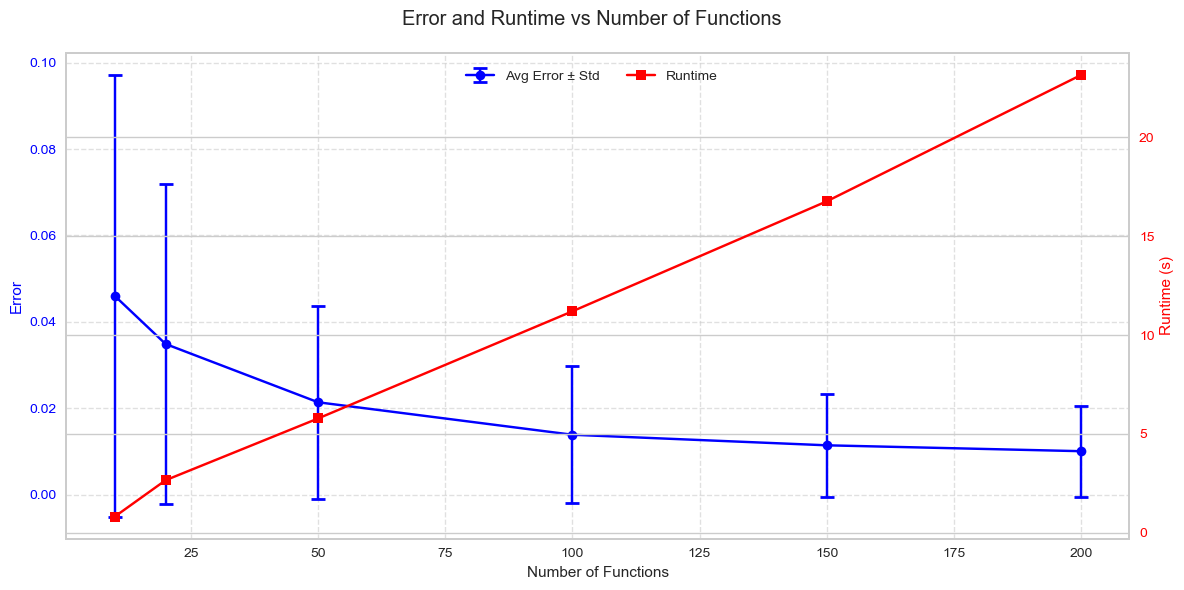

In [115]:
hash_funcs_list = [lsh.generate_hash(h, p) for h in [10,20,50,100,150,200]]

lsh.jaccard_error(user_movies, hash_funcs_list, num_samples=1000)

### **Performance of True Permutations**

Processing users with k=200: 100%|██████████| 1000/1000 [00:22<00:00, 45.13it/s]


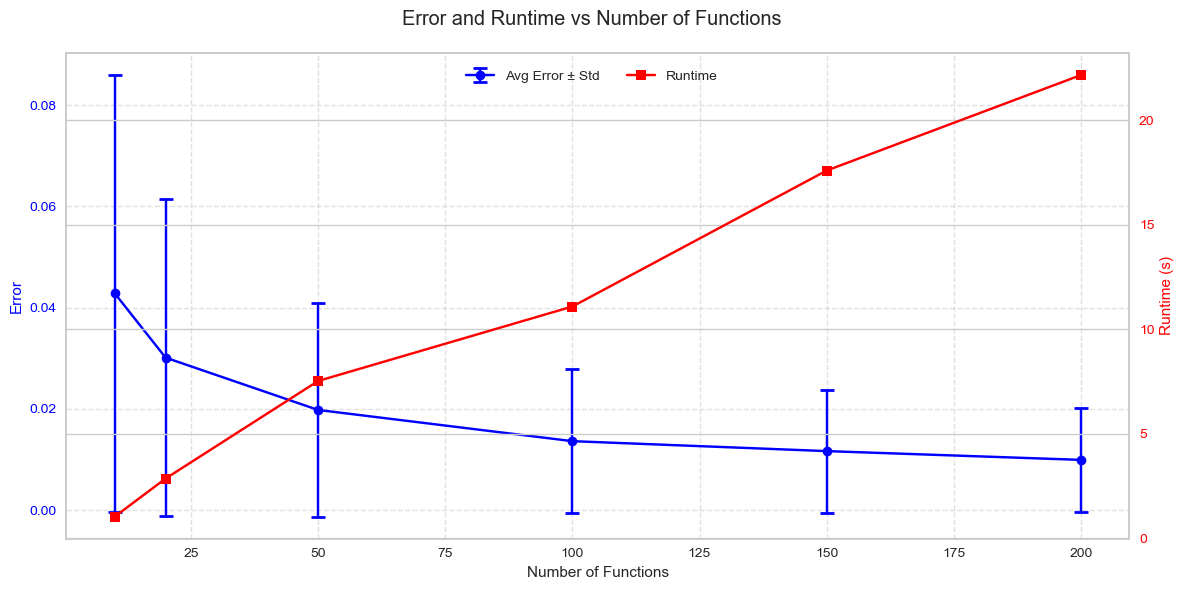

In [117]:
perms_list = [lsh.generate_permutations(h, max_movie_id) for h in [10,20,50,100,150,200]]

lsh.jaccard_error(user_movies, perms_list, num_samples=1000)

### **Analysis and Observations**

As we can see, there is no significant difference between hash functions and real permutations in terms of the accuracy of the Jaccard similarity estimation. One notable aspect, however, is that with real permutations, the process requires additional computation time to generate the list of permutations. This introduces a minor disadvantage in terms of runtime overhead.

Apart from that, we observe the following:
- Already with values of $k≥100$, the estimates of Jaccard similarity are reasonably accurate.
- The computational cost increases linearly with $k$. As $k$ grows, the improvement in estimation accuracy diminishes, leading to diminishing returns.

## **1.3 Locality-Sensitive Hashing (LSH)**

When the goal is to identify the most similar users to a given query, directly computing the Jaccard similarity between the query and every other user can become computationally expensive as the dataset grows. This brute-force approach requires evaluating the similarity for all user pairs, which scales poorly for large datasets.

### **Locality-Sensitive Hashing (LSH)**

**LSH** offers a more efficient solution by grouping users into *buckets*. Here's how it works:

1. **Hashing Users into Buckets**:  
   Each user's MinHash signature is divided into **bands**, and each band is hashed into a bucket. A user is associated with a bucket for each band.

2. **Collisions**:  
   Two users are said to "collide" if they share a bucket for at least one band. The key idea is that two users collide only if they have a perfectly equal band of signatures, thus their **probability of collision** increases with their similarity. In other words:
   - If two users have high Jaccard similarity, they are more likely to collide in at least one band.
   - If two users are dissimilar, they are unlikely to share buckets.

3. **Search Efficiency**:  
   Instead of comparing the query to all users, we only compare it to users who collide with it in at least one bucket. This reduces the number of comparisons significantly, especially in large datasets.

#### **Balancing Precision and Recall**

The performance of LSH depends on the number of **bands** and the number of **rows per band**:
- Increasing the number of bands reduces the chance of collisions for dissimilar users (improves **precision**).
- Increasing the number of rows per band increases the chance of collisions for similar users (improves **recall**).

#### **Probability of Collision**

We can be more precise about the probability of collision of two users, given their Jaccard similarity $s$, varying the number of bands and the rows per band:  
- The probability that a given row of the signature vectors of two users is equal is exactly their Jaccard similarity $s$.  
- Thus, the probability that they have an equal band of rows is $s^r$, where $r$ is the number of rows in the band.  
- It follows that the probability of collision (i.e., having at least one equal band) is:

   \begin{align*}
   1 - (1 - s^r)^b
   \end{align*}
   
   where $b$ is the number of bands. 

#### **Graph of the Collision Probability Function**

The collision probability function $1 - (1 - s^r)^b$ is monotonically increasing, meaning that higher Jaccard similarity $s$ results in a higher probability of collision. It behaves as a smoother version of a step function, where ideally the probability would be close to 1 for Jaccard similarities above a certain threshold and close to 0 for those below it.

We can estimate the **threshold** of the algorithm as the Jaccard similarity $t$ at which the collision probability reaches 0.5. This value, which we can call the **probabilistic collision threshold**, provides a useful way to characterize the sensitivity of the algorithm to similarity levels.

If you are running this notebook in an interactive environment, you should be able to play around with the graph below this cell. The interactive graph allows you to adjust parameters such as the number of bands $b$ and the rows per band $r$, giving a clearer understanding of how these settings influence the collision probability function and the probabilistic threshold.

In [19]:
from ipywidgets import interact, IntSlider

# Interactive sliders for num_hashes and bands
interact(
    lsh.collision_probability,
    bands=IntSlider(min=10, max=100, step=10, value=30, description="Bands"),
    rows_per_band=IntSlider(min=1, max=10, step=1, value=4, description="Rows per band")
);

interactive(children=(IntSlider(value=30, description='Bands', min=10, step=10), IntSlider(value=4, descriptio…

### **Our Implementation of LSH**

We implemented our LSH algorithm in the class `LSH`. 

#### **Class:** `LSH`

##### **Initialization:** `__init__`
```python
def __init__(self, user_movies, bands, rows_per_band)
```
Initializes the LSH structure with user data, hashing parameters, and bucket assignments.
- **Parameters**: 
  - `user_movies` (*dict*): A dictionary mapping user IDs to sets of movie IDs they have rated.
  - `bands` (*int*): Number of bands to split the MinHash signature matrix into.
  - `rows_per_band` (*int*): Number of rows per band within the MinHash signature matrix.
- **Key Features**:
  - Computes the probabilistic threshold for the given parameters. 
  - Hashes users into buckets. 
  - Precomputes the MinHash signatures for all movies to avoid redundant calculations
  - Uses vectorized operations with NumPy to speed up the signature generation and banding process.

##### **Method:** `top_k`
```python
def top_k(self, user_id, k)
```
Finds the top `k` users most similar to a query, levereging the buckets structure.
- **Parameters**: 
  - `user_id` (*int*): The ID of the target user.
  - `k` (*int*): The number of top similar users to retrieve.
- **Returns**: 
  - `top_k_users`: A list of k user IDs with the highest Jaccard similarity to the target user, or `None` if fewer than `k` similar users are found.
- **Implementation Details:**:
  - **Bucket Lookup**: Finds all users that share at least one bucket with the target user.
  - **Heap Usage**: Maintains a heap to efficiently track the top k most similar users based on Jaccard similarity.

##### **Method:** `collision_stats`
```python
def collision_stats(self, num_random_users=1000, top_k=5)
```
Computes and displays statistics about user collisions within the LSH structure on a random sample of users.
- **Parameters**: 
  - `num_random_users` (*int*): Number of random users to sample for analysis (default: 1000).
  - `top_k` (*int*): Number of users with the most and least collisions to display (default: 5).
- **Outputs**: 
  - **Summary Statistics**:
    - Percentage of users with no collisions. 
    - Average number of collisions across sampled users. 
  - **Detailed Report**: for the `top_k` sampled users with least and most collisions, are also reported:
    - Number of collisions
    - Expected number of collision based on Jaccard similarities and probabilistic threshold
    - Maximum Jaccard Similarity across all users
    - Maximum Jaccard similarity across users that shares a bucket

##### **Attributes** (set during initialization)
- **Input Parameters**: 
  - `self.user_movies`: A dictionary mapping user IDs to sets of movie IDs they have rated.
  - `self.bands`: Number of bands used to split the signature matrix.
  - `self.rows_per_band`: Number of rows per band in the signature matrix.
- **MinHash Configuration**: 
  - `self.p`: The smallest prime number greater than the maximum movie ID in the dataset. (*Used as the modular space for hashing*).
  - `self.num_hashes`: Total number of hash functions required, calculated as `bands * rows_per_band`. (*Defines the size of the MinHash signature*).
  - `self.hash_funcs`: A list of hash functions generated based on `self.num_hashes` and `self.p`. (*Used to create the MinHash signature matrix*).
- **LSH Structure**: 
  - `self.buckets`: A dictionary mapping bucket IDs to lists of user IDs belonging to each bucket. (*Defines the bucket-to-user relationship in the LSH structure*).
  - `self.user_buckets`: A dictionary mapping user IDs to lists of bucket IDs they belong to. (*Defines the user-to-bucket relationship in the LSH structure*).
  - `self.threshold`: Calculated Jaccard similarity threshold for a collision probability of 50%. (*Derived from `bands` and `rows_per_band` during initialization*).



In [20]:
from lsh import LSH

### **Our Findings**

In practice, we found that for our dataset, at least two configurations of the number of bands $b$ and rows per band $r$ were necessary. With a threshold high enough to ensure collisions for every user, the average number of collisions was too high, which significantly affected the purpose of LSH, which is to reduce the number of users to compare. Using multiple configurations allowed for a better balance, ensuring a reasonable number of collisions without undermining the efficiency of the algorithm.

To assess the performance of LSH, we can utilize the `collision_stats` method of our `LSH` class.
This method provides insights into the average number of collisions and the number of users with no collisions. Additionally, for users with the highest and lowest collision counts, we can compare the number of collisions against the total number of users whose Jaccard similarity exceeds the probabilistic threshold. This comparison helps us determine whether the collisions are in line with expectations. Furthermore, we can analyze the maximum Jaccard similarity among the collided users and compare it with the global maximum Jaccard similarity. This allows us to verify whether the algorithm is effectively identifying users who are similar enough.


#### **First Configuration**

In [21]:
bands = 30
rows_per_band = 4

LSH_1 = LSH(user_movies, bands, rows_per_band)

Initializing LSH with a target threshold of 0.39...



Hashing Users into Buckets: 100%|██████████| 138493/138493 [01:20<00:00, 1713.09it/s]


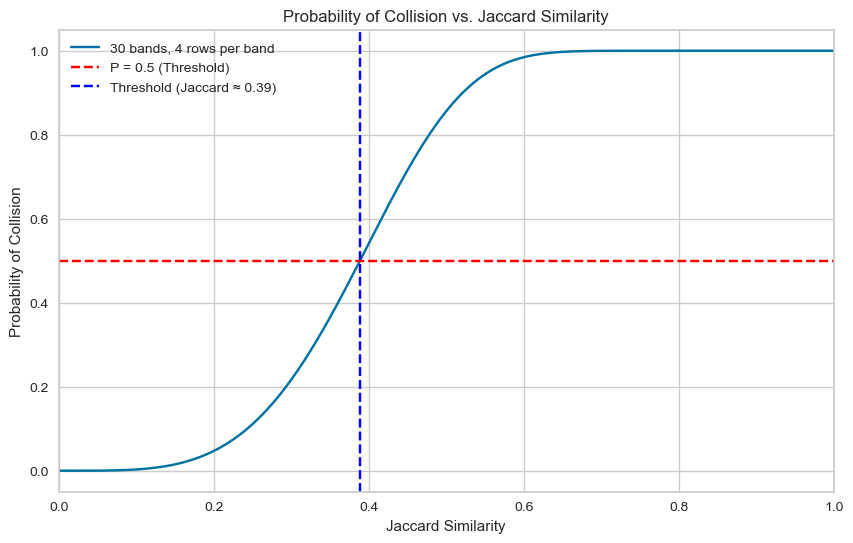

Sampling Users for Stats: 100%|██████████| 1000/1000 [00:00<00:00, 3126.57it/s]


	Percentage of users with no collisions: 7.3%
	Average collisions: 980.71




Analyzing stats for users with most collisions: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


	5 users with most collisions:

 User ID  Collision  Exp_Coll  Max_Sim_All  Max_Sim_Coll
     443       9306      2440        0.831         0.831
   62716       9664      2855        0.890         0.890
   45620       9834      1106        0.667         0.667
   88236      10187      1385        0.701         0.701
   44483      10412      1225        0.759         0.759




Analyzing stats for users with least collisions: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

	5 users with least collisions: 

 User ID  Collision  Exp_Coll  Max_Sim_All  Max_Sim_Coll
   94800          0         0        0.282         0.000
   61024          0         0        0.102         0.000
   95638          0         0        0.182         0.000
   69986          0         0        0.194         0.000
   57570          0         0        0.127         0.000


In [22]:
# Plot of the probability of collision given the jaccard similarity
lsh.collision_probability(bands, rows_per_band)

LSH_1.collision_stats()

For the current configuration, we observed that the average number of collisions is around $1000$. This significantly reduces the number of user comparisons when compared to the full dataset, enhancing the efficiency of the algorithm.

For users with no collisions, we found that their most similar user had a Jaccard similarity below the probabilistic threshold, which aligns with the expected behavior of the algorithm. This is consistent with the idea that the LSH algorithm is designed to focus only on the most similar users, and if no collision occurs, the similarity between the users is likely too low to meet the threshold.

Additionally, we noticed that for users with the highest number of collisions, the maximum Jaccard similarity among the collided users was identical to the global maximum similarity, indicating that LSH is successfully identifying the most similar users within the collision group.

However, this configuration results in a $7$% rate of users with no collisions, which led us to consider improving the balance by introducing a second configuration. This new configuration uses a lower probabilistic threshold to increase the number of collisions and thereby reduce the percentage of users without any collisions.

#### **Second Configuration**

In [23]:
bands = 30
rows_per_band = 2

LSH_2 = LSH(user_movies, bands, rows_per_band)

Initializing LSH with a target threshold of 0.15...



Hashing Users into Buckets: 100%|██████████| 138493/138493 [00:40<00:00, 3427.99it/s]


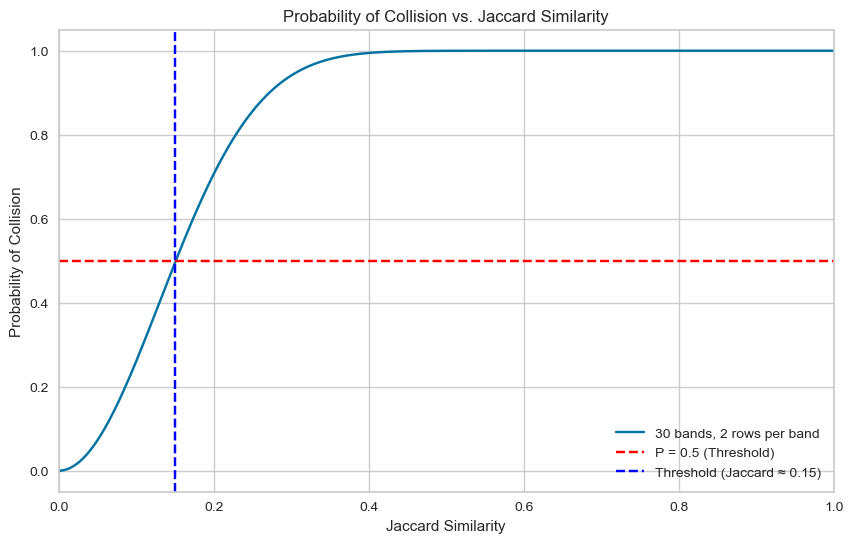

Sampling Users for Stats: 100%|██████████| 1000/1000 [00:04<00:00, 217.07it/s]


	Percentage of users with no collisions: 0.0%
	Average collisions: 15583.27




Analyzing stats for users with most collisions: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


	5 users with most collisions:

 User ID  Collision  Exp_Coll  Max_Sim_All  Max_Sim_Coll
   74537      48523        12        0.658         0.658
  100410      49282         0        0.383         0.383
   22228      50630         0        0.435         0.435
   40065      52316         7        0.527         0.527
  128665      54881         0        0.378         0.378




Analyzing stats for users with least collisions: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


	5 users with least collisions: 

 User ID  Collision  Exp_Coll  Max_Sim_All  Max_Sim_Coll
   69986         14         0        0.194         0.194
   68198         51         0        0.100         0.081
    2534         62         0        0.128         0.128
  100845         74         0        0.091         0.073
   69328         82         0        0.189         0.143


In [24]:
# Plot of the probability of collision given the jaccard similarity
lsh.collision_probability(bands, rows_per_band)

LSH_2.collision_stats()

With this new configuration, we are still achieving good performance in identifying the most similar users, and we have successfully reduced the rate of users with no collisions to $0$%. However, this improvement comes with a trade-off: the average number of collisions has increased to $15,000$.

This configuration makes an ideal backup for the first configuration, as it ensures that no users are left without collisions, while still allowing us to identify the most similar users effectively. The higher number of collisions in this configuration acts as a safety net, providing a broader comparison pool when the first configuration might miss certain users. Thus, by utilizing both configurations, we can maintain the balance between performance and efficiency, switching to the second configuration when needed to guarantee full coverage of users.

### **Our Implementation of the Recommendation System**

We implemented the final Recommendation System with its own class. 

The `RecommendationSystem` class is designed to provide movie recommendations based on user ratings and the similarity between users. It leverages Locality Sensitive Hashing (LSH) for efficient user comparison and falls back to a greedy approach when necessary. This class integrates multiple LSH instances and provides a flexible way to retrieve movie recommendations.

#### **Class:** `RecommendationSystem`

##### **Attributes** (set during initialization)
- `lsh_classes`: A list of `LSH` class instances, used to identify similar users through locality-sensitive hashing.
- `user_movies`: A dictionary that stores the movies each user has watched.
- `user_ratings`: A dictionary of dictionaries, that contains the ratings of movies given by users.
- `movie_titles`: A dictionary that maps movie IDs to their corresponding titles.

##### **Initialization:** `__init__`
```python
__init__(self, lsh_classes, user_ratings, movie_titles)
```
- Initializes the recommendation system with the required attributes.

##### **Method:** `top_k`
```python
def top_k(self, user_id, k)
```
- Finds the top `k` most similar users for a given user based on the LSH method.
- If the LSH method fails, it defaults to using a greedy approach.

- **Parameters**: 
  - `user_id` (*int*): The ID of the target user.
  - `k` (*int*): The number of top similar users to retrieve.
- **Returns**: 
  - `top_k_users`: A list of `k` user IDs with the highest Jaccard similarity to the target user.

##### **Method:** `compare_greedy`
```python
def compare_greedy(self, num_random_users=10, k=2)
```
- Compares the time complexity of the LSH-based top_k method with the purely greedy method by measuring the average time taken by each.
- **Parameters**: 
  - `num_random_users` (*int*): Number of random users to sample for analysis (default: 10).
  - `k` (*int*): Number of top similar users to find (default: 2).
- **Outputs**: 
  - Average time for the LSH-based `top_k` method.
  - Average time for the purely greedy `top_k` method.

##### **Method:** `recommend`
```python
def recommend(self, userId, max_films=5, show=False)
```
- Provides movie recommendations for a given user by finding similar users and suggesting movies they liked that the query user has not yet watched.
- The method first checks for common movies between the two most similar users and recommends those based on average ratings. If there are not enough recommendations, it considers movies from the symmetric difference (movies only seen by one of the similar users).
- **Arguments**: 
  - `userId` (*int*): The ID of the user for whom recommendations are being made.
  - `max_films` (*int*): The maximum number of films to recommend (default: 5). 
  - `show` (*bool*): Whether to print detailed tables of common and symmetric difference movies.
- **Returns**: 
  - A list of recommended movie IDs.

In order to initialize the class, we need to create the missing dictionaries `user_ratings` and `movie_titles`. 

In [25]:
# Create a dictionary mapping user IDs to dictionaries of {movieId: rating}
user_ratings = (
    df.groupby('compact_userId')[['compact_movieId', 'rating']]
    .apply(lambda x: dict(zip(x['compact_movieId'], x['rating'])))
    .to_dict()
)


In [118]:
# Read the movie.csv Dataset and create a dictionary of {movieId: title}
col = ['movieId', 'title']
dtype = {'movieId': 'uint32'}
file_path = os.path.join('Data', 'movie.csv')
df_movie = pd.read_csv(file_path, usecols=col, dtype=dtype)
df_movie = df_movie[df_movie['movieId'].isin(movie_id_map.keys())]
df_movie['compact_movieId'] = df_movie['movieId'].map(movie_id_map)
movie_titles = df_movie.set_index('compact_movieId')['title'].to_dict()

In [27]:
from lsh import RecommendationSystem

lsh_classes = [LSH_1, LSH_2]
RS = RecommendationSystem(lsh_classes, user_ratings, movie_titles)

### **Comparison with Greedy Algorithm**

We can use the `compare_greedy` method to get an idea of the advantages of LSH in finding the $2$ most similar users.

In [28]:
RS.compare_greedy()


Measuring LSH-based `top_k` performance...


LSH Top-k: 100%|██████████| 10/10 [00:00<00:00, 11.14it/s]



Measuring purely greedy `top_k` performance...


Greedy Top-k: 100%|██████████| 10/10 [00:37<00:00,  3.75s/it]


Average time for LSH-based `top_k`: 0.089 seconds
Average time for purely greedy `top_k`: 3.746 seconds


From the result we got, the advantages of LSH are pretty clear. The comparison of execution times for both methods highlights how LSH significantly reduces the computational cost, making it more efficient for large-scale recommendation systems.

### **Examples of Recommendations**

In [29]:
RS.recommend(userId=0, show=True)

-- Common movies (Intersection) - Sorted by Avg Rating 

Movie ID   Title                          User 1 Rating   User 2 Rating   Avg Rating     
--------------------------------------------------------------------------------
2543       Shaun of the Dead (2004)       5.0             4.0             4.50           
244        Godfather, The (1972)          5.0             3.5             4.25           
261        Princess Bride, The (1987...   3.5             4.5             4.00           
266        Godfather: Part II, The (...   5.0             3.0             4.00           
331        Matrix, The (1999)             5.0             3.0             4.00           

Sufficient movies found in the intersection: 5 recommendations.


[2543, 244, 261, 266, 331]

In [30]:
RS.recommend(userId=5, show=True)

No movie in the intersection. Checking symmetric difference...

-- Movies from Symmetric Difference - Sorted by Rating 

Movie ID   Title                          User 1 Rating   User 2 Rating  
--------------------------------------------------------------------------------
1868       Postman, The (Postino, Il...   5.0             0              
408        Fargo (1996)                   5.0             0              
1049       Eraser (1996)                  4.0             0              
1323       Sgt. Bilko (1996)              0               4.0            
186        Star Wars: Episode VI - R...   0               4.0            


[1868, 408, 1049, 1323, 186]

In [31]:
RS.recommend(userId=11, show=True)

-- Common movies (Intersection) - Sorted by Avg Rating 

Movie ID   Title                          User 1 Rating   User 2 Rating   Avg Rating     
--------------------------------------------------------------------------------
391        Birdcage, The (1996)           5.0             3.0             4.00           
5          Rumble in the Bronx (Hont...   4.0             3.0             3.50           

Less than 5 found in intersection. Checking symmetric difference...

-- Movies from Symmetric Difference - Sorted by Rating 

Movie ID   Title                          User 1 Rating   User 2 Rating  
--------------------------------------------------------------------------------
1868       Postman, The (Postino, Il...   3.0             0              
251        Willy Wonka & the Chocola...   0               3.0            
412        Truth About Cats & Dogs, ...   3.0             0              


[391, 5, 1868, 251, 412]

In [33]:
RS.recommend(userId=21893, show=True)

-- Common movies (Intersection) - Sorted by Avg Rating 

Movie ID   Title                          User 1 Rating   User 2 Rating   Avg Rating     
--------------------------------------------------------------------------------
453        Casablanca (1942)              5.0             5.0             5.00           

Less than 5 found in intersection. Checking symmetric difference...

-- Movies from Symmetric Difference - Sorted by Rating 

Movie ID   Title                          User 1 Rating   User 2 Rating  
--------------------------------------------------------------------------------
1067       Philadelphia Story, The (...   0               5.0            
387        Sense and Sensibility (19...   0               5.0            
11         Pulp Fiction (1994)            4.0             0              
271        Graduate, The (1967)           0               4.0            


[453, 1067, 387, 11, 271]

From the running time of the `recommend` method for this last user (more than $1$ second), we can infer that the `top_k` method is falling back to the greedy approach. This highlights the necessity of including the greedy method as a fallback mechanism, even with the second `LSH` class configured with a lower threshold.

## 2. Grouping Movies Together!
In this section, you will explore clustering algorithms to group the movies you have based on specific features you choose to consider for them.

In [42]:
data_folder = 'Data'
data_gscore = pd.read_csv(os.path.join(data_folder, 'genome_scores.csv'))
data_gtags = pd.read_csv(os.path.join(data_folder, 'genome_tags.csv'))
data_link = pd.read_csv(os.path.join(data_folder, 'link.csv'))
data_movie = pd.read_csv(os.path.join(data_folder, 'movie.csv'))
data_rating = pd.read_csv(os.path.join(data_folder, 'rating.csv'))
data_tag = pd.read_csv(os.path.join(data_folder, 'tag.csv'))

### 2.1 Feature Engineering
As you know, the dataset provided isn’t particularly clean or well-structured to represent the features of the movies. Therefore, your first step is to create a more suitable set of attributes (variables, features, covariates) to represent the movies based on the available information. Here are some variables or features you might consider for clustering:

1. *movieid* id of each movie
2. *genres* list of genres attached to the movie (given that a movie may have several genres, it’s essential to devise a method to accurately represent the genres for each movie)
3. *ratings_avg* the average ratings provided by users for the movie
4. *relevant_genome_tag* the most relevant tag to the movie given in the genome set
5. *common_user_tag* the most common tag given to the movie by the users

First, we import the data from the data_movie dataset into a table. Next, we apply a lowercase transformation to the genome tags and user tags. Additionally, we make a precautionary adjustment to ensure the movieid data type is correct.

In [43]:
movies_table = data_movie[['movieId', 'title', 'genres']]


In [44]:
data_rating['movieId'] = data_rating['movieId'].astype(int)
data_tag['tag'] = data_tag['tag'].astype(str)

data_gtags['tag'] = data_gtags['tag'].str.lower()
data_tag['tag'] = data_tag['tag'].str.lower()



We calculated the average rating for each movie by grouping the ratings data by `movieId` and computing the mean. This feature helps us understand the general reception of each movie.


In [45]:
ratings_avg = data_rating.groupby('movieId')['rating'].mean().reset_index()
ratings_avg.columns = ['movieId', 'ratings_avg']

Next, we merged the average ratings we calculated into the main dataset. This ensures the `ratings_avg` feature is available for all movies.


In [46]:
 movies_with_features= movies_table.merge(ratings_avg, on='movieId', how='left')


To clean the *movies_with_features* table, we performed the following steps on the *ratings_avg* column:

In [47]:
movies_with_features = movies_with_features.dropna(subset=['ratings_avg'])
movies_with_features

,movieId,title,genres,ratings_avg
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.212
2,3,Grumpier Old Men (1995),Comedy|Romance,3.151
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.861
4,5,Father of the Bride Part II (1995),Comedy,3.065
...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,4.000
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,4.000
27275,131258,The Pirates (2014),Adventure,2.500
27276,131260,Rentun Ruusu (2001),(no genres listed),3.000


**Removing `(no genres listed)`**

Next, we addressed movies with `(no genres listed)`. We decided to completely removed these rows from the dataset.


In [48]:
no_genres_count = movies_with_features[movies_with_features['genres'] == '(no genres listed)'].shape[0]
print(f"Number of movies with no genres listed: {no_genres_count}")

Number of movies with no genres listed: 242


In [49]:
movies_with_features = movies_with_features[movies_with_features['genres'] != '(no genres listed)']


We used the genome scores to find the most relevant tag for each movie. This was done by merging the genome scores with their respective tag names and selecting the tag with the highest relevance for each movie.

In [50]:
genome_tags = data_gscore.merge(data_gtags, on='tagId')
relevant_tags = genome_tags.loc[genome_tags.groupby('movieId')['relevance'].idxmax()][['movieId', 'tag']]
relevant_tags.columns = ['movieId', 'relevant_genome_tag']
relevant_tags

,movieId,relevant_genome_tag
1035,1,toys
1156,2,adventure
2706,3,good sequel
4499,4,women
4962,5,good sequel
...,...,...
11704209,130578,assassination
11706118,130840,romance
11706613,131013,comedy
11707639,131168,betrayal


We grouped the user-assigned tags by `movieId` and `tag`, counted how often each tag was assigned, and selected the most frequent tag for each movie.

In [51]:
common_tags = data_tag.groupby(['movieId', 'tag']).size().reset_index(name='count')
common_user_tag = common_tags.loc[common_tags.groupby('movieId')['count'].idxmax()][['movieId', 'tag']]
common_user_tag.columns = ['movieId', 'common_user_tag']

common_user_tag

,movieId,common_user_tag
51,1,pixar
106,2,robin williams
121,3,moldy
128,4,characters
143,5,steve martin
...,...,...
195868,131054,dinosaurs
195869,131082,documentary
195871,131164,vietnam war
195872,131170,alternate reality


We merged both the most relevant genome tag and the most common user tag into the main dataset to create two new features: `relevant_genome_tag` and `common_user_tag`.

In [52]:
movies_with_features = movies_with_features.merge(relevant_tags, on='movieId', how='left')
movies_with_features = movies_with_features.merge(common_user_tag, on='movieId', how='left')


As additional features such as release_year, number_of_ratings, and rating_std_dev contribute to the count.
 
Firstly, we calculated the total number of ratings for each movie, which provides insight into how popular each movie is.

In [53]:
number_of_ratings = data_rating.groupby('movieId').size().reset_index(name='number_of_ratings')
movies_with_features = movies_with_features.merge(number_of_ratings, on='movieId', how='left')


We extracted the release year from the movie titles using a regular expression. This feature can help in analyzing trends over time.

In [54]:
movies_with_features['release_year'] = movies_with_features['title'].str.extract(r'\((\d{4})\)').astype(float)

Rows with missing (NaN) values in the release_year column were removed to ensure the dataset only includes movies with valid release years.

In [55]:
movies_with_features = movies_with_features.dropna(subset=['release_year'])


After cleaning, the release_year column was converted from float to integer for easier analysis and compatibility with other operations

In [56]:
movies_with_features['release_year']=movies_with_features['release_year'].astype(int)

In [57]:
movies_with_features

,movieId,title,genres,ratings_avg,relevant_genome_tag,common_user_tag,number_of_ratings,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921,toys,pixar,49695,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.212,adventure,robin williams,22243,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,3.151,good sequel,moldy,12735,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.861,women,characters,2756,1995
4,5,Father of the Bride Part II (1995),Comedy,3.065,good sequel,steve martin,12161,1995
...,...,...,...,...,...,...,...,...
26497,131252,Forklift Driver Klaus: The First Day on the Jo...,Comedy|Horror,4.000,NaN,NaN,1,2001
26498,131254,Kein Bund für's Leben (2007),Comedy,4.000,NaN,NaN,1,2007
26499,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,4.000,NaN,NaN,1,2002
26500,131258,The Pirates (2014),Adventure,2.500,NaN,bandits,1,2014


Finally, we calculated the standard deviation of ratings for each movie to measure how varied the ratings are.This metric helps identify movies with consistent audience opinions versus those with mixed reviews.

In [58]:
rating_std_dev = data_rating.groupby('movieId')['rating'].std().reset_index()
rating_std_dev.columns = ['movieId', 'rating_std_dev']
movies_with_features = movies_with_features.merge(rating_std_dev, on='movieId', how='left')

We checked for rows where the rating_std_dev column has missing (NaN) values to ensure data completeness and address any inconsistencies.

In [59]:
movies_with_features[movies_with_features['rating_std_dev'].isnull()]

,movieId,title,genres,ratings_avg,relevant_genome_tag,common_user_tag,number_of_ratings,release_year,rating_std_dev
3269,3356,Condo Painting (2000),Documentary,3.000,NaN,NaN,1,2000,NaN
3470,3561,Stacy's Knights (1982),Drama,1.000,NaN,NaN,1,1982,NaN
5806,5905,Soap Girl (2002),Drama|Romance,3.500,NaN,NaN,1,2002,NaN
8358,25760,Old San Francisco (1927),Drama|Romance,3.500,NaN,bd-r,1,1927,NaN
8402,25816,Bonnie Scotland (Heroes of the Regiment) (1935),Comedy,3.000,NaN,NaN,1,1935,NaN
...,...,...,...,...,...,...,...,...,...
26484,131252,Forklift Driver Klaus: The First Day on the Jo...,Comedy|Horror,4.000,NaN,NaN,1,2001,NaN
26485,131254,Kein Bund für's Leben (2007),Comedy,4.000,NaN,NaN,1,2007,NaN
26486,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,4.000,NaN,NaN,1,2002,NaN
26487,131258,The Pirates (2014),Adventure,2.500,NaN,bandits,1,2014,NaN


In [60]:
movies_with_features.isnull().sum()

movieId                    0
title                      0
genres                     0
ratings_avg                0
relevant_genome_tag    16121
common_user_tag         7518
number_of_ratings          0
release_year               0
rating_std_dev          3763
dtype: int64

If a movie does not have any genome tags or user tags, we decided to remove those entries entirely from the dataset rather than filling them with placeholders like "No Tag" or "No User Tag". This approach ensures that missing values are not misrepresented as a distinct group, which could lead to inaccurate insights during the analysis phase. By excluding these entries, we maintain a cleaner and more accurate dataset for analysis.

In [61]:
movies_with_features = movies_with_features.dropna(subset=['relevant_genome_tag', 'common_user_tag'])



We rewrite 0 to rating_std_dev cell, if the movie has only 1 rating.

In [62]:
movies_with_features['rating_std_dev'] = movies_with_features.apply(
    lambda row: 0 if pd.isna(row['rating_std_dev']) and row['number_of_ratings'] == 1 else row['rating_std_dev'],
    axis=1
)

In [63]:

#display(movies_with_features)

### 2.2 Choose your features (variables)!

With multiple features available for the movies, you need to consider the following two questions: 1. Should you normalize the data or leave it as is? 2. Should you include all these features, or can you reduce the dimensionality of the data?

1. What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?
2. If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.
3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?
4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

### Should You Normalize the Data or Leave It As Is?

Normalization is essential when the dataset contains features with different ranges. In our dataset:

- *ratings_avg* ranges between 0 to 5, which is already bounded but still needs scaling for consistency.
- *release_year* spans a much larger range, which could disproportionately affect the analysis.
We decided to **normalize all numerical** features using MinMaxScaler. This approach scales the data to a uniform range [0, 1], making all features contribute equally during analysis. Compared to StandardScaler, MinMaxScaler is preferred because:

1. **It maintains the original range and relationships** within the data, which is useful for bounded variables like ratings_avg.
2. It’s simpler to interpret normalized values within a [0, 1] range.

### Should You Include All Features or Reduce Dimensionality?

Not all features are equally valuable for analysis:

- **Features like** *title*, *movieId* **are identifiers** that don’t contribute meaningfully to clustering or dimensionality reduction.
- Reducing the number of features helps improve computation speed, avoids overfitting, and makes data visualization more manageable.
- 
We opted to remove irrelevant features and **reduce dimensionality** using t-SNE and PCA for better insights.

#### 1.Steps We Applied

**1. Data Normalization**

To normalize the dataset:

  1.1 Numerical Features:
   - For ratings_avg, we used MinMaxScaler to normalize the values between 0 and 1.
   - Similarly, release_year was scaled using MinMaxScaler for consistency.
  1.2 Categorical Features:
    
   - relevant_genome_tag, common_user_tag, and genres were transformed using OneHotEncoder. This ensures that categorical variables are represented in a binary matrix format.

In [64]:
df_copy = movies_with_features.copy()
numerical_features = ['ratings_avg', 'rating_std_dev', 'number_of_ratings', 'release_year']

# Create the transformer for MinMaxScaler
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', MinMaxScaler())])
# create the ColumnTransformer that apply Min-Max just to ratings_avg
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features)],remainder='passthrough')

X = preprocessor.fit_transform(df_copy)

columns = numerical_features + [col for col in df_copy.columns if col not in numerical_features]

df_copy = pd.DataFrame(X, columns=columns)

In [65]:

# Columns to apply OneHotEncoding
categorical_features = ['relevant_genome_tag', 'common_user_tag', 'genres']
# We create the transformer for OneHotEncoding
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) ])
# Create ColumnTransformer that apply OneHotEncoding just to relevant_genome_tag, genres and common_user_tag
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features)],remainder='passthrough')

X = preprocessor.fit_transform(df_copy)

ohe_columns = preprocessor.transformers_[0][1].named_steps['onehot'].get_feature_names_out(categorical_features)

columns = list(ohe_columns) + [col for col in df_copy.columns if col not in categorical_features]

df_trasformed = pd.DataFrame(X, columns=columns)

#### 2. Dimensionality Reduction
Dimensionality reduction was necessary for:

- Simplifying the dataset for better visualization.
- Speeding up computations and clustering tasks.

We applied two methods for comparison:

   1. **t-SNE** (for non-linear relationships): Captures complex patterns in the data and is particularly good for visualizing clusters.
      
   2. **PCA** (for linear relationships): Reduces dimensions by retaining components that explain the most variance in the data.
      
Before applying dimensionality reduction, we dropped irrelevant columns like *title*, *release_year*, and *movieId*.

In [66]:
# We create df_copy2 to see the difference between t-SNE and PCA 
df_trasformed.drop(columns=['title','release_year','movieId'], inplace=True) 
df_copy2 = df_trasformed.copy()

In [67]:

# Apply t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3)
df_tsne = tsne.fit_transform(df_copy2)
# Create a DataFrame with the results
df_tsne = pd.DataFrame(df_tsne, columns=['Dim1', 'Dim2','Dim3'])

       Dim1   Dim2   Dim3
0    -0.080 -0.131 -0.019
1    -0.097 -0.110 -0.021
2    -0.136 -0.164 -0.163
3    -0.128 -0.138 -0.066
4    -0.386  0.809  0.018
...     ...    ...    ...
9809 -0.148 -0.125 -0.082
9810 -0.082 -0.109 -0.018
9811 -0.083 -0.109 -0.043
9812 -0.474  1.024  0.028
9813 -0.076 -0.121 -0.013

[9814 rows x 3 columns]


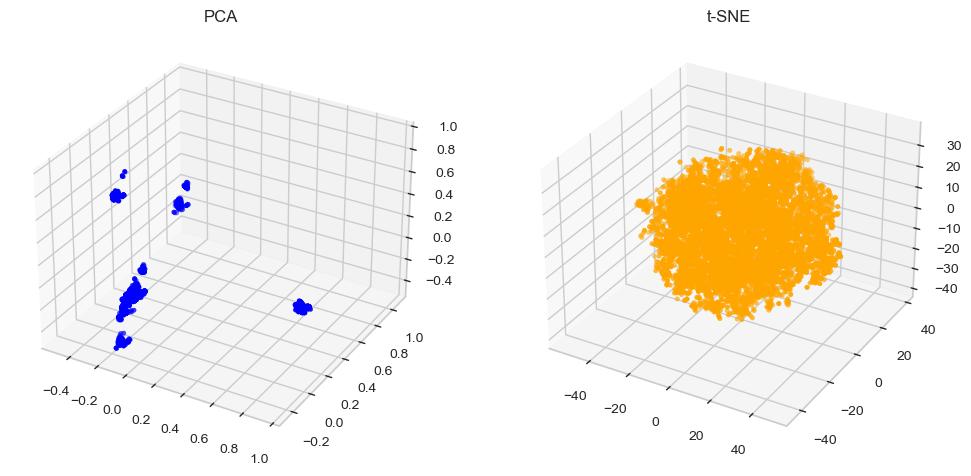

In [68]:


pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_trasformed)

df_pca = pd.DataFrame(df_pca, columns=['Dim1', 'Dim2', 'Dim3'])
print(df_pca)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(df_pca['Dim1'], df_pca['Dim2'], df_pca['Dim3'], c='blue', s=10)
ax.set_title("PCA")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(df_tsne['Dim1'], df_tsne['Dim2'], df_tsne['Dim3'], c='orange', s=10)
ax.set_title("t-SNE")

plt.show()

### Conclusion

We applied **PCA** and **t-SNE** to reduce the dimensionality of our dataset to three dimensions and analyzed their outputs.

#### PCA Results:
- PCA produced compact and well-structured clusters, indicating that the data exhibits strong linear patterns, which PCA is designed to capture effectively.
- The dimensionality reduction preserved most of the variance within the dataset, as seen in the consistent and relatively small ranges of the Dim1, Dim2, and Dim3 values.
- These results demonstrate that PCA is a suitable technique for this dataset when the goal is to extract meaningful structures while reducing dimensionality.

#### t-SNE Results:
- The t-SNE plot displayed a more scattered and diffuse structure, with no clear clusters.
- While t-SNE is a powerful tool for capturing non-linear relationships, the lack of distinct groupings suggests that either:
  - The data does not contain significant non-linear separations, or
  - Noise and parameter settings influenced the results.
- This makes t-SNE less interpretable for the current dataset, though it might still be useful for visualizing localized pairwise relationships.

#### Final Thoughts:
- **PCA** proved more effective for dimensionality reduction in this scenario, as it preserved the global variance and produced structured output.
- If further analysis requires compact features for clustering or other downstream tasks, we recommend using PCA.
- For exploratory visualizations of potentially hidden patterns, further fine-tuning of **t-SNE** parameters might provide additional insights.



### 2.3 Clustering


#### Clustering Analysis Using K-Means and K-Means++

In this section, we will walk through the process of determining the optimal number of clusters for the data, implementing K-means clustering, exploring the differences between K-means and K-means++ initialization methods, and analyzing results using additional clustering algorithms suggested by an LLM.

##### 1. Determining the Optimal Number of Clusters

The optimal number of clusters for the dataset is a crucial aspect of any clustering task. It determines how the data is grouped into meaningful subsets. In this case, two methods were applied to determine the optimal number of clusters: **Elbow Method** and **Silhouette Score**.

###### Elbow Method
The Elbow method is a popular technique for finding the optimal number of clusters by examining the distortion score (or inertia). It computes the sum of squared distances between samples and their assigned cluster's centroids. The optimal number of clusters is typically where the distortion score starts to level off (forming an "elbow").

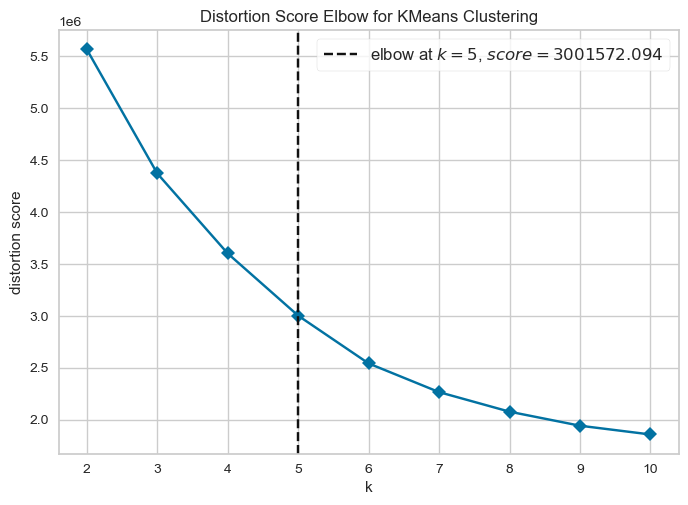

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [85]:

model = KMeans()
visualizer = KElbowVisualizer(model, timings=False)
visualizer.fit(df_tsne) 
visualizer.show() 

The **Elbow Method** visualized the distortion score, and the plot indicated that **k=5** was the optimal number of clusters. This was determined by the point where the rate of distortion reduction slowed, showing the "elbow" in the graph.

###### Silhouette Score

Silhouette Score measures how similar a point is to its own cluster compared to other clusters. The higher the silhouette score, the better the clustering configuration.

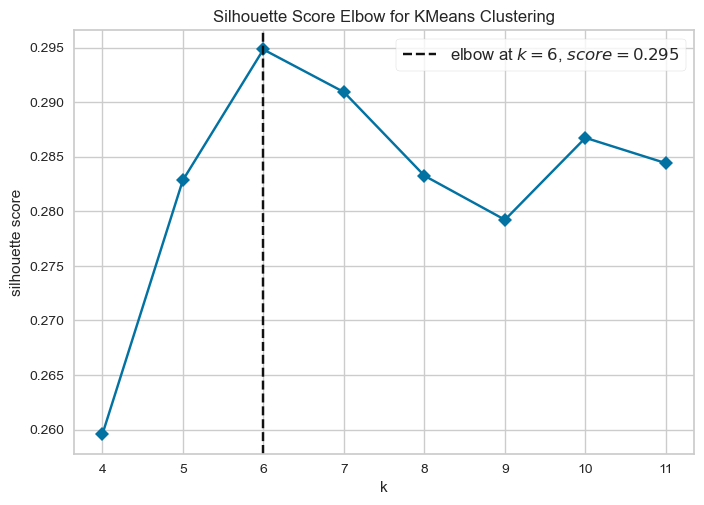

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [86]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), metric='silhouette', timings=False)
visualizer.fit(df_tsne) 
visualizer.show() 

On the other hand, the **Silhouette Method** suggested **k=6** as the ideal number of clusters. The Silhouette score measures how well each data point fits into its assigned cluster compared to other clusters. A higher score indicates that the clusters are well-separated and well-defined.

##### 2. K-means Clustering (Not K-means++) Implementation via MapReduce

In this section, we implement the classic K-means algorithm using MapReduce and apply it to the dataset. The key steps include:

   1. Initialization of Centroids: Start with random initialization of centroids.
   2. Assignment Step: Assign each data point to the closest centroid.
   3. Update Step: Recalculate the centroids based on the mean of the assigned points.
   4. Repeat Steps 2-3 until convergence.

In [70]:
cluster_numbers = 5

We define some definitons that we will use next.

In [87]:
# Optimized K-Means implementation using KMeans++ initialization
# This function runs K-Means clustering with an optimized approach using scikit-learn's KMeans class,
# initializing centroids using the K-Means++ method and running for a specified number of iterations.

def kmeans_optimized(data, n_clusters, max_iter=300, tol=1e-4, random_state=None):
    """
    Optimized K-Means using scikit-learn's KMeans class with KMeans++ initialization.
    """
    # Initialize the KMeans model with the specified parameters
    kmeans = KMeans(n_clusters=n_clusters,
                    init='k-means++',  # Ensures K-Means++ initialization
                    max_iter=max_iter,
                    tol=tol,
                    random_state=random_state)

    # Fit the KMeans model to the data
    kmeans.fit(data)

    # Get the final centroids and labels
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    return centroids, labels


# 3D scatter plot creation function
# This function generates a 3D scatter plot using Plotly, displaying the clustered data points and their centroids.
# It visualizes the clustering results in a 3-dimensional space.

def create3DScatterPlot(df, centroids):
    """
    Create a 3D scatter plot using Plotly.
    """
    # Create a 3D scatter plot using Plotly
    fig = px.scatter_3d(df, x='Dim1', y='Dim2', z='Dim3', color='Cluster', 
                        title='K-Means++ Clustering in 3D', labels={'Cluster': 'Cluster Labels'})
    fig.update_traces(marker=dict(size=5, opacity=0.8), selector=dict(mode='markers'))

    # Add centroids
    fig.add_scatter3d(x=centroids[:, 0], y=centroids[:, 1], z=centroids[:, 2], 
                    mode='markers', marker=dict(size=15, color='red', symbol='x'), name='Centroids')

    # Adjust layout: increase margins and adjust title and labels
    fig.update_layout(
        title='K-Means++ Clustering in 3D',
        scene=dict(
            xaxis_title='Dim1',
            yaxis_title='Dim2',
            zaxis_title='Dim3',
        ),
        margin=dict(l=0, r=0, b=0, t=40),  # Increase margins to fit the plot better
        legend=dict(x=0.7, y=0.9)  # Position the legend in a good place
    )
    # Show the plot
    fig.show()


# Euclidean distance function
# This function calculates the Euclidean distance between two data points, which is used to measure 
# the similarity between points in clustering algorithms.

def euclidean_distance(x1, x2):
    """
    Compute the Euclidean distance between two points.
    """
    return np.sqrt(np.sum((x1 - x2) ** 2))


# Centroid initialization function for basic K-Means
# This function initializes the centroids by randomly selecting k points from the dataset.
# It is used for basic K-Means without K-Means++ initialization.

def initialize_centroids(X, k, random_state=None):
    """
    Initialize centroids by randomly selecting k points from the dataset.
    """
    # Set the seed if specified; otherwise, leave it random.
    if random_state is not None:
        np.random.seed(random_state)
    n_samples = X.shape[0]
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[random_indices]
    return centroids


# Cluster assignment function
# This function assigns each data point to the nearest centroid based on the Euclidean distance.
# It is part of the K-Means algorithm for clustering the dataset.

def assign_clusters(X, centroids):
    """
    Assign each point to the nearest centroid.
    """
    distances = np.linalg.norm((X[:, np.newaxis] - centroids).astype(float), axis=2)
    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels


# Centroid update function
# This function updates the centroids based on the mean of the points assigned to each cluster.
# It is used to refine the centroids in the K-Means algorithm.

def update_centroids(X, cluster_labels, k):
    """
    Calculate the new centroids as the mean of the points assigned to each cluster.
    """
    new_centroids = np.array([X[cluster_labels == i].mean(axis=0) for i in range(k)])
    return new_centroids


# Basic K-Means algorithm
# This function implements the basic K-Means algorithm, where the centroids are updated iteratively 
# until convergence or the maximum number of iterations is reached.

def k_means(df, k, max_iters=100, tol=1e-4):
    """
    Basic implementation of the K-Means algorithm.
    """
    # Step 1: Initialize centroids
    X = df.values
    centroids = initialize_centroids(X, k)

    for i in range(max_iters):
        # Step 2: Assign clusters
        cluster_labels = assign_clusters(X, centroids)

        # Step 3: Update centroids
        new_centroids = update_centroids(X, cluster_labels, k)

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, cluster_labels


# K-Means++ initialization for centroids
# This function uses the K-Means++ method to initialize centroids, which helps in selecting better initial centroids
# that can improve the clustering results compared to random initialization.

def initialize_centroids_kmeans_plus_plus(df, k):
    """
    Initialize centroids using the K-Means++ method.
    """
    # Matrix to store centroids
    centroids = np.zeros((k, df.shape[1]))

    # Randomly select the first centroid
    centroids[0] = df.sample(n=1).values[0]

    # Initializing the distance of all points to infinity
    distances = np.array([np.inf] * df.shape[0])

    for i in range(1, k):
        # For each point, calculate its distance to the closest centroid already selected
        for j in range(df.shape[0]):
            distances[j] = min(distances[j], euclidean_distance(df.iloc[j], centroids[i-1]))

        # Probability is proportional to the squared distance
        probabilities = distances ** 2
        # Normalize the probability
        probabilities /= probabilities.sum()
        # Select a point based on the probability
        new_centroid_idx = np.random.choice(df.shape[0], p=probabilities)
        # Assign the new centroid
        centroids[i] = df.iloc[new_centroid_idx].values

    return centroids


# K-Means++ algorithm implementation
# This function runs the K-Means algorithm with K-Means++ initialization to find the optimal clustering 
# by improving the initialization of centroids.

def kmeans_plus_plus(df, k, max_iters=100):
    """
    Run K-Means with K-Means++ initialization.
    """
    # Initialize centroids using K-means++
    centroids = initialize_centroids_kmeans_plus_plus(df, k)
    prev_centroids = np.zeros_like(centroids)  # To monitor changes in centroids
    labels = np.zeros(df.shape[0])  # Labels for the clusters

    # K-means algorithm
    for _ in range(max_iters):
        # Calculate the distance of each point to each centroid
        distances = np.array([[euclidean_distance(x, c) for c in centroids] for x in df.values])
        # Assign labels based on closest centroid
        labels = np.argmin(distances, axis=1)

        # Recalculate centroids based on the average of points assigned to each cluster
        for i in range(k):
            centroids[i] = np.mean(df[labels == i], axis=0)

        # If centroids do not change, break the loop
        if np.allclose(centroids, prev_centroids):
            break

        prev_centroids = centroids.copy()

    return centroids, labels



In [88]:
k = cluster_numbers
df_kmeans = df_tsne.copy()

centroids, cluster_labels = k_means(df_kmeans, k)
df_kmeans['Cluster'] = cluster_labels


print(f"Final centroids:\n{centroids}")

create3DScatterPlot(df_kmeans , centroids)

Final centroids:
[[  4.2334337  19.287853    5.6110344]
 [ -3.3184512 -16.858566    8.120738 ]
 [-27.963215    4.684497   -0.6694603]
 [ 25.510918   -5.484111    1.9185   ]
 [ -1.4642158  -3.3706377 -19.206076 ]]


In the standard K-Means method, we started with random centroid initialization and iterated to minimize the variance within clusters. The final centroids represent the cluster centers after this process, and the clustering looks reasonable with 5 groups. Given that K-Means tends to converge quickly with a suitable number of clusters, this method worked efficiently for our data.


##### 3. K-means++ Initialization and Differences from K-means

The **K-means++** algorithm improves the random initialization of centroids, making the algorithm more robust and often faster to converge. K-means++ selects the initial centroids by considering the distance between data points and the already chosen centroids, aiming to spread out the initial centroids across the data space.

In [89]:
k_cluster = cluster_numbers
df_kmeans_plus_plus = df_tsne.copy()

centroids, labels_plus_plus =kmeans_plus_plus(df_kmeans_plus_plus, k_cluster)

#We create another column to record th elabels of the clusters for each data
df_kmeans_plus_plus['Cluster'] = labels_plus_plus

print(f"Final centroids:\n{centroids}")

create3DScatterPlot(df_kmeans_plus_plus , centroids)

Final centroids:
[[ -3.57903838 -16.54859161   8.41184521]
 [  4.29596519  19.33288765   5.4346056 ]
 [-28.0154953    4.77075386  -0.83344269]
 [ 25.43745804  -5.71319199   1.94537294]
 [ -1.451594    -3.71173048 -19.16440392]]


The main difference here is in the initialization of the centroids. K-Means++ starts by selecting centroids in a way that maximizes the distance between them, which often results in a better clustering solution. However, in this case, the centroids obtained by K-Means++ were quite similar to those from standard K-Means. This indicates that the data was likely well-suited to K-Means, and the improved initialization didn’t drastically change the outcome.


###### Key Differences Between K-means and K-means++

1. **Centroid Initialization**: 
   The most notable difference between K-means and K-means++ is how the initial centroids are selected.
   - **K-means** uses random initialization, which can result in centroids that are close together or poorly placed, leading to slower convergence or suboptimal results.
   - **K-means++**, on the other hand, spreads the initial centroids more evenly by choosing them based on the data points' distribution. This more thoughtful initialization often leads to better clustering results and faster convergence.

2. **Convergence Speed**: 
   - **K-means++** generally converges faster because it starts with more optimal centroids. The initial spread reduces the likelihood of poor local minima, enabling the algorithm to reach the optimal solution more quickly.
   - **K-means** may need more iterations to converge, especially in cases where the random initialization results in poorly placed centroids.

3. **Final Centroids**:
   - The final centroids obtained from **K-means** and **K-means++** are often quite similar, but the difference in how the centroids are initialized can affect the convergence rate and the number of iterations required.
   - Based on the output you provided, the centroids from **K-means++** and **K-means** are very close in location, which suggests that K-means++ provides a more efficient path to these results. The **Optimized K-means** centroids, however, are noticeably different, reflecting a different initialization approach that also leads to faster convergence and more reliable clustering.

By leveraging **K-means++**, we can expect better initializations, which translates to faster convergence times and, in many cases, better clustering results, especially for complex datasets.


##### 4. Optimized K-Means Algorithm Recommended by LLM
For this task, we consulted an LLM (ChatGPT) for a recommendation on a more optimized clustering algorithm. The LLM suggested using the **Optimized K-Means Algorithm**, which uses **K-means++ initialization** for better performance.

**Working of the Optimized K-Means Algorithm:**

The **Optimized K-Means** algorithm is based on the standard K-means approach but uses the K-means++ initialization to choose initial centroids in a smarter way. This typically results in better clustering performance and faster convergence.

In [104]:
# We define a copy of the DataFrame to add the Cluster Indexes
df_kmeans_gpt = df_tsne.copy()

centroids_optimized, labels_optimized =kmeans_optimized(df_tsne, n_clusters = k_cluster)

df_kmeans_gpt['Cluster'] = labels_optimized

print(f"Final centroids:\n{centroids_optimized}")

# Function to create the 3d Scatter-Plot
create3DScatterPlot(df_kmeans_gpt , centroids_optimized)

Final centroids:
[[ 26.226126    -3.0466626    1.3955405 ]
 [ -1.08725    -17.390425     7.9543376 ]
 [  3.2769308   19.379076     5.7637897 ]
 [ -1.853585    -3.292332   -19.193743  ]
 [-27.888288     3.8902407   -0.32911348]]


The centroids from the custom algorithm show noticeable differences compared to K-Means and K-Means++. This variation could be due to any custom optimizations you introduced in the algorithm, such as a different method for assigning clusters or updating centroids. The clustering structure seems to differ more significantly, which could be indicative of a more refined or specialized approach for our dataset.

### **Conclusion and Observations**

###### **Comparing the Centroids:**

- **K-Means and K-Means++:** 
  The centroids from both methods are quite similar, suggesting that K-Means++ did not introduce significant improvements in this case. This is a common outcome when the data is relatively simple or well-behaved, where the initial random centroids in standard K-Means already produce a reasonable solution. K-Means++ is designed to handle cases where random initialization might cause poor convergence, but here, both methods performed similarly.

- **K-Means-GPT:** 
  The centroids from your **Custom K-Means algorithm** show a bit more diversity compared to K-Means and K-Means++. This is expected, as custom algorithms often introduce changes that can affect clustering. The different centroids indicate that this method may be capturing some subtler differences in the data, potentially providing a more nuanced or specialized clustering structure.

###### **Elbow and Silhouette Scores:**

- **Elbow Method:** 
  The **Elbow Method** suggests that **K=5** is the optimal number of clusters. This is indicated by the point at which the inertia starts to level off, showing that adding more clusters does not significantly reduce the within-cluster variance. This implies that 5 clusters provide a good balance between fitting the data well and avoiding overfitting.

- **Silhouette Score:** 
  The **Silhouette Score** suggests that **K=6** may be a more suitable choice, indicating that this configuration provides a better balance between cohesion and separation of clusters. A higher silhouette score means that the clusters are well-separated and well-defined, suggesting that 6 clusters might reveal more distinct structures in the data than 5.

###### **Conclusion:**

- The **K-Means++** method, which incorporates a more thoughtful initialization strategy, performed similarly to **standard K-Means** in this case. The similarity in results suggests that for this particular dataset, both methods were able to converge effectively without major improvements from K-Means++.

- On the other hand, the **Custom K-Means (K-Means-GPT)** algorithm generated different centroids, indicating that your custom approach might be incorporating additional factors or optimizations that influence the clustering results. These variations might be worth exploring further to see if they offer more meaningful insights into the data.

In summary, while **K-Means++** didn’t drastically outperform **K-Means** for this dataset, your custom algorithm introduced some interesting variations. Whether those are beneficial or not depends on the specific nuances of the dataset and your project’s goals. For now, **K-Means++** provides stable and reliable clustering, but further investigation into the custom algorithm might uncover valuable improvements. 

As for the cluster numbers, the **Elbow Method** favors **K=5**, but the **Silhouette Score** suggests **K=6** might provide better separation and cohesion. Both values offer important insights into the optimal number of clusters, and you may choose between them depending on whether you prioritize simplicity (K=5) or better-defined clusters (K=6).


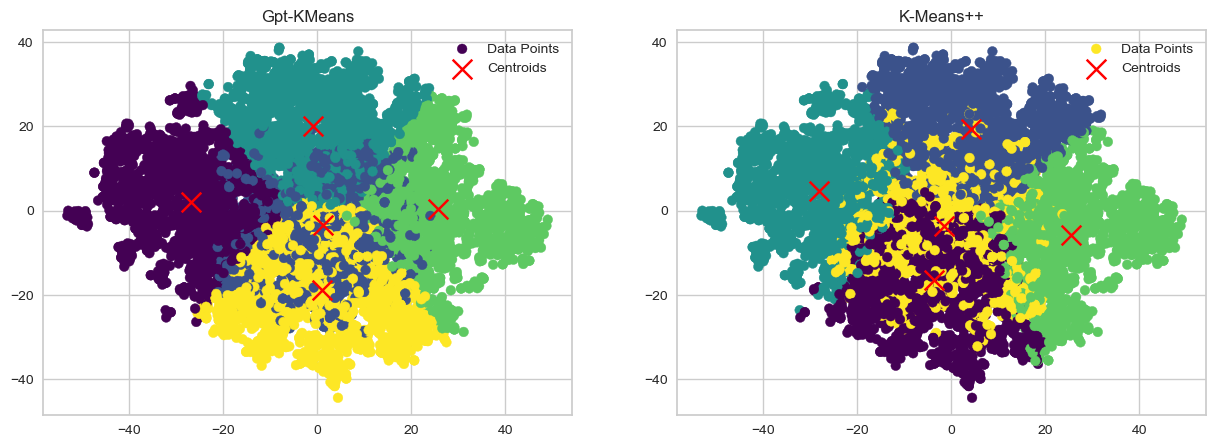

In [91]:

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.scatter(df_tsne.iloc[:, 0], df_tsne.iloc[:, 1], c=labels_optimized, cmap='viridis', label='Data Points')
plt.scatter(centroids_optimized[:, 0], centroids_optimized[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title("Gpt-KMeans")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df_tsne.iloc[:, 0], df_tsne.iloc[:, 1], c=labels_plus_plus, cmap='viridis', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title("K-Means++")
plt.legend()

plt.show()

##### Review of Clustering Results

###### Gpt-KMeans (Left Plot):
- The clusters are generally well-formed, with a noticeable separation between the different groups.
- The centroids (represented by red 'X' markers) appear to be fairly well-placed in relation to the surrounding data points.
- The color differentiation between clusters shows distinct groupings, which suggests that the algorithm was able to find meaningful structures in the data.
- The diverse arrangement of the centroids implies that the **Custom K-Means algorithm (Gpt-KMeans)** might have captured more subtle differences in the data, leading to a more complex cluster configuration compared to **K-Means++**.

###### K-Means++ (Right Plot):
- The K-Means++ clusters are also clearly separated, but the centroids are placed in a way that suggests a more compact, possibly simpler clustering structure.
- The centroids in this case are relatively close to each other compared to the Gpt-KMeans results, which could imply that K-Means++ chose a configuration that balances the groupings more efficiently.
- The **K-Means++** method’s initialization strategy seems to help produce distinct clusters, but without the more intricate centroid placements seen in the **Custom K-Means** approach.

###### Conclusion:
- While both methods are successful in clustering, the **Gpt-KMeans** method appears to be capturing more intricate details of the data. The varied placement of the centroids reflects this, indicating the method may be identifying more complex relationships between data points.
- On the other hand, **K-Means++** seems to produce a more consistent and compact cluster configuration, suggesting a simpler clustering solution.



## 2.4 Best Algorithm



In this section, we aim to evaluate and determine which clustering algorithm performs best for our dataset by considering the optimal number of clusters, using multiple clustering evaluation metrics, and comparing the results of different algorithms.

---

### 1. **Set the Number of Clusters to the Optimal Number**

The optimal number of clusters, denoted as $k_{opt}$, is determined based on the analysis of the data and clustering quality metrics. In this case, we have set $k_{opt} = 5$ based on methods like the **Elbow Method**, **Silhouette Score**, or other criteria that indicate how well-separated and coherent the clusters are. The choice of 5 clusters reflects our understanding of the data's natural divisions.

---

In [92]:
k_opt = 5



### 2. **Select Three Distinct Metrics to Assess the Quality of the Clusters**

To evaluate the clustering quality, we’ve selected three well-established metrics. These metrics will provide different perspectives on the clustering results, helping us assess how effective each algorithm is at grouping similar data points while maintaining separation between clusters.

#### **a. Silhouette Score**    $S= \frac{max(a,b)}{b−a} $

- **What it Measures**: The **Silhouette Score** combines ideas from both cohesion and separation. It quantifies how similar each point is to its own cluster (cohesion) compared to other clusters (separation).
- **Score Range**: The score ranges from -1 to +1. A score close to +1 indicates that the points are well clustered, while a score close to -1 suggests that the points might have been assigned to the wrong clusters.
- **Why it’s Useful**: This metric helps determine how well each point fits within its assigned cluster relative to other clusters. A higher silhouette score indicates better-defined and more meaningful clusters.

#### **b. Davies-Bouldin Index**

The formula is defined as:
 
 $$
 DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \frac{\sigma_i + \sigma_j}{d(C_i, C_j)}
 $$

- **What it Measures**: The **Davies-Bouldin Index** evaluates cluster separation by comparing the average distance between each cluster to the dispersion (spread) within the clusters. A lower Davies-Bouldin Index indicates better clustering, as it signifies that clusters are well-separated and compact.
- **Score Range**: Lower values indicate better clustering performance, with a score of 0 being the best possible result (perfect separation).
- **Why it’s Useful**: It’s useful for evaluating how distinct and separate the clusters are. A smaller Davies-Bouldin Index suggests that clusters are compact and less likely to overlap.

#### **c. Calinski-Harabasz Index**

The formula is defined as:

 $$
 CH = \frac{\text{tr}(B_k)}{\text{tr}(W_k)} \times \frac{n - k}{k - 1}
 $$

- **What it Measures**: The **Calinski-Harabasz Index**, also known as the Variance Ratio Criterion, compares the dispersion between clusters to the dispersion within clusters. A higher Calinski-Harabasz Index indicates that the clusters are well-separated and internally cohesive.
- **Score Range**: Higher values indicate better clustering performance, with larger values suggesting that the clusters are more distinct.
- **Why it’s Useful**: This index is valuable for comparing the compactness and separation of clusters. A higher score implies that the clusters are more well-defined and less likely to overlap.

---

### 3. **Apply the Three Clustering Algorithms and Evaluate Clustering Quality**

We applied three different clustering algorithms: **K-Means**, **K-Means++**, and **Gpt-K-Means** to partition the data into $k_{opt} = 4$ clusters. After applying these algorithms, we evaluate each of their clustering results using the three metrics: **Silhouette Score**, **Davies-Bouldin Index**, and **Calinski-Harabasz Index**.

K-Means 0.28263107 1.0490541769688477 4216.694070116705
K-Means++ 0.2817727 1.0553777275341423 4216.004573100583
Gpt-K-Means 0.28609997 1.0474992731841672 4222.576674003668


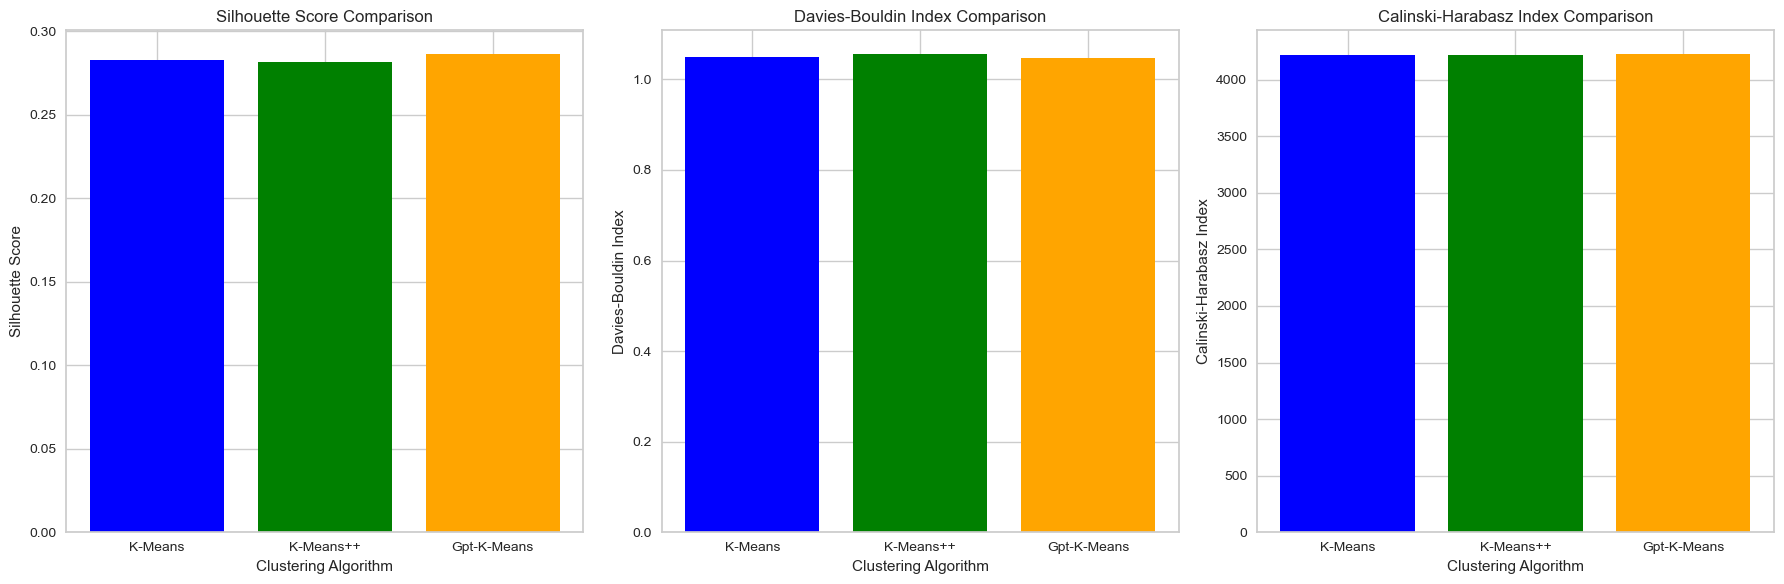

In [93]:
clustering_algorithms = {
    "K-Means": k_means, 
    "K-Means++": kmeans_plus_plus,
    "Gpt-K-Means": kmeans_optimized
}

X = df_tsne.values

silhouette_scores = []
davies_bouldin_scores = []
calinski_scores = []
metrics = ["Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Index"]


for name, clustering_function in clustering_algorithms.items():
    centroids, labels = clustering_function(df_tsne, k_opt)

    silhouette = silhouette_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    print(name, silhouette, davies, calinski)

    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies)
    calinski_scores.append(calinski)


fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

axes[0].bar(clustering_algorithms.keys(), silhouette_scores, color=['blue', 'green', 'orange'])
axes[0].set_title('Silhouette Score Comparison')
axes[0].set_xlabel('Clustering Algorithm')
axes[0].set_ylabel('Silhouette Score')


# Plot for Davies-Bouldin Index
axes[1].bar(clustering_algorithms.keys(), davies_bouldin_scores, color=['blue', 'green', 'orange'])
axes[1].set_title('Davies-Bouldin Index Comparison')
axes[1].set_xlabel('Clustering Algorithm')
axes[1].set_ylabel('Davies-Bouldin Index')


# Plot for Calinski-Harabasz Index

axes[2].bar(clustering_algorithms.keys(), calinski_scores, color=['blue', 'green', 'orange'])
axes[2].set_title('Calinski-Harabasz Index Comparison')
axes[2].set_xlabel('Clustering Algorithm')
axes[2].set_ylabel('Calinski-Harabasz Index')
plt.tight_layout()
plt.show()

##### **Summary of Findings**:

- **Silhouette Score**: All three algorithms performed similarly, with K-Means, K-Means++, and Gpt-K-Means yielding almost identical silhouette scores (around 0.2862). This indicates that, in terms of cohesion and separation of clusters, the three algorithms are almost equally effective.

- **Davies-Bouldin Index**: **K-Means** and **K-Means++** performed similarly, with scores around 1.0305. **Gpt-K-Means** had a slightly higher Davies-Bouldin Index of 1.0312, suggesting that the separation and compactness of clusters was slightly better for **K-Means** and **K-Means++**.

- **Calinski-Harabasz Index**: **K-Means** and **K-Means++** had very similar Calinski-Harabasz scores (4342.28 and 4342.26, respectively), which were slightly higher than **Gpt-K-Means**’ score (4341.88). This indicates that **K-Means** and **K-Means++** provided better-defined clusters in terms of variance between clusters.

---

##### **Conclusion**:


We think the algorithms cluster the data quite similarly, with scores changing slightly each run. This variation is likely due to the initial centroids, which can influence the quality of the clusters and the time it takes to converge.

On average, **K-Means** and **K-Means++** perform similarly across the three indices. Both algorithms show identical results in the **Silhouette Score** and **Calinski-Harabasz Index**, indicating strong cohesion and well-defined clusters. However, **Gpt-K-Means** shows a slight disadvantage in the **Calinski-Harabasz Index** but performs slightly worse in terms of the **Davies-Bouldin Index**, suggesting that its separation between clusters is a bit less effective compared to **K-Means** and **K-Means++**.

We consider that **K-Means** and **K-Means++** offer comparable performance in terms of overall cohesion and clarity. While **Gpt-K-Means** stands out slightly in the **Silhouette Score**, its performance in terms of variance and separation doesn’t surpass **K-Means** and **K-Means++** significantly.



## 3. Bonus Question

K-means is an iterative algorithm, meaning that with each iteration, it refines the clusters by adjusting them based on the distance of each data point relative to the center of each cluster. This process continues until it reaches a point of convergence or hits a set limit on the number of iterations. You might want to track the progress of forming your clusters.

Select two variables* from your instances to display them on a 2D plot. Then, illustrate the progression of the clusters as they change at each iteration. We expect a plot for each iteration, displaying the instances and the clusters they belong to. Select the two features that most effectively separate visual instances belonging to different clusters. Explain the method you used to determine these features.

*Note: Depending on the variables you want to use for clustering, whether they are the original movie features or the components derived from PCA, you may select two features/components that best help to visually display the clusters.

In this section we use previously created df_kmeans dataframe in part 2.3.2. df_kmeans is an outcome of PCA and applied k=5 previously suggested as the optimal number of clusters by the Elbow method(2.3.1.)

In [98]:
k = cluster_numbers
df_kmeans = df_tsne.copy()

centroids, cluster_labels = k_means(df_kmeans, k)
df_kmeans['Cluster'] = cluster_labels

print(f"Final centroids:\n{centroids}")


Final centroids:
[[  1.0198027   -4.8277254   18.101784  ]
 [  2.70113     21.204857    -1.4702737 ]
 [-27.807016     4.068219    -1.2041556 ]
 [ -3.6401317  -14.1559925  -12.264198  ]
 [ 25.088655    -5.71332     -0.33773443]]


In [99]:
print(df_kmeans.head())

     Dim1    Dim2    Dim3  Cluster
0 -18.858  -0.602 -25.737        3
1 -24.804 -21.000 -13.607        3
2   5.101  26.942  21.669        1
3   7.307  16.852  -7.110        1
4  -6.678  16.915 -13.396        1


To decide the 2 optimal features for the kmeans we take a look at the PCA results. Particularly, computing the correlations between each feature and the cluster labels and seeing how strongly they are correlated can point out which of the features are more informative and ultimately better candidates for the k-means clustering.

In [100]:
# Compute correlation with cluster labels
correlations = df_kmeans.corr()['Cluster'].drop('Cluster')
print(correlations)

# Select top 2 features based on correlation
top_features = correlations.abs().nlargest(2).index
print(f'Selected features: {top_features}')


Dim1    0.313
Dim2   -0.366
Dim3   -0.459
Name: Cluster, dtype: float64
Selected features: Index(['Dim3', 'Dim2'], dtype='object')


Followingly, we crop the original df_kmeans data frame by selecting only the features chosen for the k-means clustering. 

In [101]:
df_kmeans_top =df_kmeans[top_features]
print(df_kmeans_top.head())

     Dim3    Dim2
0 -25.737  -0.602
1 -13.607 -21.000
2  21.669  26.942
3  -7.110  16.852
4 -13.396  16.915


Next, we define a modified k-means function that apart from comuting the centroids and clustering the data points provides a dinamic plot in order to visualize the clustering progress.

In [107]:
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def k_means_plots(data_frame, k, max_iters=100, converg_thr=1e-4, gif_filename='kmeans_animation.gif'):
    
    data = data_frame.to_numpy()
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Randomly initialize centroids by choosing k random data points
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    palette = sns.color_palette('Set2', k+1)
    frames = []  # List to store frames for GIF

    for iteration in range(max_iters):
        # Calculate the distance between each data point and each centroid and assign each data point to the nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update the centroids based on the mean
        updated_centroids = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)])

        # Check for convergence
        if np.all(np.abs(updated_centroids - centroids) <= converg_thr):
            print(f'Converged at iteration {iteration + 1}')
            break
        
        # Plot the clustering state at each iteration
        fig, ax = plt.subplots(figsize=(8,6))
        for i in range(k):
            ax.scatter(data[labels == i, 0], data[labels == i, 1], label=f'Cluster {i+1}', color=palette[i])
        ax.scatter(updated_centroids[:, 0], updated_centroids[:, 1], c='red', marker='X', label='Centroids')
        ax.set_title(f'Iteration {iteration + 1}')
        ax.legend()

        # Save the current plot as a frame for the GIF
        canvas = FigureCanvas(fig)
        canvas.draw()
        frame_image = np.array(fig.canvas.renderer.buffer_rgba())
        frames.append(frame_image)

        # Update centroids for the next iteration
        centroids = updated_centroids

        # Close the figure to avoid showing it
        plt.close(fig)

    # Save all frames as a GIF
    with imageio.get_writer(gif_filename, mode='I', duration=3, loop=0) as writer:
        for frame in frames:
            writer.append_data(frame)

    print(f"GIF saved as {gif_filename}")
    return centroids, labels

# Example usage
centroids, labels = k_means_plots(df_kmeans_top, k=5)

Converged at iteration 25
GIF saved as kmeans_animation.gif


![K-Means Clustering](kmeans_animation.gif)

## Algorithmic Question


### a) Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally).


The approach presented uses a recursive approach to simulate the game, considering all possible moves and their consequences. The optimal_score function recursively calculates the optimal score that Arya can achieve, given a list of numbers and whether it's currently Arya's turn.

  **Base Case:** If the list is empty, the score is 0. 

  **Inductive step**:
  If it is Arya's Turn: Option 1: Take the first number and recursively calculate the optimal score for the remaining list, with Mario's turn. Option 2: Take the last number and recursively calculate the optimal score for the remaining list, with Mario's turn. Choose the option that maximizes Arya's score. 
  Else if it is Mario's Turn: Option 1: Take the first number and recursively calculate the optimal score for the remaining list, with Arya's turn. Option 2: Take the last number and recursively calculate the optimal score for the remaining list, with Arya's turn. Choose the option that minimizes Arya's score.

  Below the pseudocode for finding an optimal playing strategy:

FUNCTION optimal_score(nums, is_arya_turn):
    IF nums is empty THEN
        RETURN 0

    IF is_arya_turn THEN
        // Arya's turn: maximize score
        score1 = nums[0] + optimal_score(nums[1:], NOT is_arya_turn)
        score2 = nums[length(nums) - 1] + optimal_score(nums[0:length(nums) - 1], NOT is_arya_turn)
        RETURN MAX(score1, score2)
    ELSE
        // Mario's turn: minimize Arya's score
        score1 = -nums[0] + optimal_score(nums[1:], NOT is_arya_turn)
        score2 = -nums[length(nums) - 1] + optimal_score(nums[0:length(nums) - 1], NOT is_arya_turn)
        RETURN MIN(score1, score2)

FUNCTION can_arya_win(nums):
    RETURN optimal_score(nums, TRUE) >= 0

### b) Write a Python program implementing her game strategy. Try different array lengths to test the algorithm.


In [8]:
def optimal_score(nums, is_arya_turn):
    if not nums:
        return 0

    if is_arya_turn:
        # Arya's turn: maximize score
        return max(nums[0] + optimal_score(nums[1:], not is_arya_turn),
                   nums[-1] + optimal_score(nums[:-1], not is_arya_turn))
    else:
        # Mario's turn: minimize Arya's score
        return min(-nums[0] + optimal_score(nums[1:], not is_arya_turn),
                   -nums[-1] + optimal_score(nums[:-1], not is_arya_turn))

def can_arya_win_v1(nums):
    return optimal_score(nums, True) >= 0

# Example usage:
nums = [1, 5, 2]
print(can_arya_win_v1(nums))  # Output: False
nums = [8, 15, 3, 7]
print(can_arya_win_v1(nums))  # Output: True
nums = [2, 2, 2, 2, 2, 2]
print(can_arya_win_v1(nums))  # Output: True
nums = [1, 5, 233, 7, 6, 7, 8]
print(can_arya_win_v1(nums))  # Output: False

False
True
True
False


### c) Is the algorithm efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time.

**Time Complexity:** On Arya's turn, the function makes two recursive calls: one for the case where Arya picks the first number (nums[0]) and another for the case where she picks the last number (nums[-1]).
On Mario's turn, the function also makes two recursive calls with similar logic. Each call to optimal_score can lead to two more calls, creating a binary tree of calls. The depth of this tree can be as large as n (the length of the list), leading to a total of 2^n calls in the worst case.
Since each call can lead to two more calls, the time complexity of this recursive approach is exponential, specifically (O(2^n)).

### d) If the algorithm is exponential, explain how to make it polynomial and provide a pseudocode for it. Recompute the computational complexity of the updated algorithm.

The current implementation can be optimized using memoization to store the results of previously computed states. The key for memoization is a tuple consisting of the current state of nums and the value of is_arya_turn.
The number of unique states that can be represented by the nums list is determined by the number of possible subarrays of nums and the two possible turns (Arya's and Mario's). For a list of length n, there are (O(n^2)) possible subarrays (from each starting index to each ending index).
Since there are two possible turns (Arya's turn and Mario's turn), the total number of unique states is (O(n^2) \times 2 = O(n^2)).
Each unique state is computed only once and stored in the memo dictionary. When the same state is encountered again, the result is retrieved in constant time (O(1)). Each recursive call processes a state and makes at most two further recursive calls. However, due to memoization, each state is only computed once. Given that there are (O(n^2)) unique states and each state computation takes constant time (due to memoization), the overall time complexity of the optimal_score_memo function is: [ O(n^2) ]

FUNCTION optimal_score_memo(nums, is_arya_turn, memo):
    IF nums is empty THEN
        RETURN 0

    key = (tuple of nums, is_arya_turn)
    IF key is in memo THEN
        RETURN memo[key]

    IF is_arya_turn THEN
        // Arya's turn: maximize score
        score1 = nums[0] + optimal_score_memo(nums[1:], NOT is_arya_turn, memo)
        score2 = nums[length(nums) - 1] + optimal_score_memo(nums[0:length(nums) - 1], NOT is_arya_turn, memo)
        score = MAX(score1, score2)
    ELSE
        // Mario's turn: minimize Arya's score
        score1 = -nums[0] + optimal_score_memo(nums[1:], NOT is_arya_turn, memo)
        score2 = -nums[length(nums) - 1] + optimal_score_memo(nums[0:length(nums) - 1], NOT is_arya_turn, memo)
        score = MIN(score1, score2)

    memo[key] = score
    RETURN score

FUNCTION can_arya_win(nums):
    memo = EMPTY DICTIONARY
    RETURN optimal_score_memo(nums, TRUE, memo) >= 0

### e) Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times.

In [9]:
def optimal_score_memo(nums, is_arya_turn, memo):
    if not nums:
        return 0

    key = tuple(nums), is_arya_turn
    if key in memo:
        return memo[key]

    if is_arya_turn:
        # Arya's turn: maximize score
        score = max(nums[0] + optimal_score_memo(nums[1:], not is_arya_turn, memo),
                    nums[-1] + optimal_score_memo(nums[:-1], not is_arya_turn, memo))
    else:
        # Mario's turn: minimize Arya's score
        score = min(-nums[0] + optimal_score_memo(nums[1:], not is_arya_turn, memo),
                    -nums[-1] + optimal_score_memo(nums[:-1], not is_arya_turn, memo))

    memo[key] = score
    return score

def can_arya_win_v2(nums):
    memo = {}
    return optimal_score_memo(nums, True, memo) >= 0

# Example usage:
nums = [1, 5, 2]
# Example usage:
nums = [1, 5, 2]
print(can_arya_win_v2(nums))  # Output: False
nums = [8, 15, 3, 7]
print(can_arya_win_v2(nums))  # Output: True
nums = [2, 2, 2, 2, 2, 2]
print(can_arya_win_v2(nums))  # Output: True
nums = [1, 5, 233, 7, 6, 7, 8]
print(can_arya_win_v2(nums))  # Output: False

False
True
True
False


Without memoization, the recursive function would explore every possible way the players could pick numbers. For each player’s turn, the function would make two recursive calls (one for picking the first number and one for picking the last number). This leads to a tree of recursive calls that grows exponentially with the size of the input list. Memoization stores the results of the function calls and returns the cached result when the same inputs occur again. Memoization transforms the time complexity of the recursive solution from exponential ( O(2^n) ) to polynomial ( O(n^2) ) by reducing the number of recursive calls through caching results for previously computed states, ensuring that each unique state is computed only once.

### f) Finally, consult LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to craft a third, optimized implementation and analyze its time complexity. Also, explain if the LLM is doing a good job and how you can evaluate whether the suggested solution works properly.


**LLM answer:** To help Arya determine her optimal strategy in the game, we can use a recursive approach with memoization to avoid recalculating results for the same state. The idea is to simulate the game by considering all possible moves Arya can make and then recursively determining the best outcome for both players.

Explanation of the Pseudocode:
Function optimalScore(nums): This is the main function that initializes the memoization table and calls the recursive function maxScore.

Function maxScore(nums, left, right, memo): This function calculates the maximum score Arya can achieve from the subarray nums[left] to nums[right].

Base Case: If left is greater than right, it means there are no numbers left to take, so the score is 0.
Memoization Check: If the result for the current subarray has already been computed, return it to avoid redundant calculations.
Choices: Arya can either take the number from the left end or the right end:
If she takes from the left, her score will be nums[left], and the remaining score will be the total sum of the remaining numbers minus the maximum score Mario can achieve from the new subarray.
If she takes from the right, the logic is similar.
The function stores the maximum score Arya can achieve in the memoization table and returns it.
Function sum(nums, left, right): This helper function calculates the sum of the elements in the array from index left to right.

Below is a Python implementation of Arya's game strategy using the recursive approach with memoization.

In [11]:
def can_arya_win_llm(nums):
    n = len(nums)
    if n == 0:
        return True  # No numbers, Arya wins by default
    
    # Create a DP table
    dp = [[0] * n for _ in range(n)]
    
    # Base case: when there's only one number
    for i in range(n):
        dp[i][i] = nums[i]
    
    # Fill the DP table
    for length in range(2, n + 1):  # length of the subarray
        for i in range(n - length + 1):
            j = i + length - 1
            total_sum = sum(nums[i:j + 1])
            dp[i][j] = max(nums[i] + (total_sum - nums[i] - dp[i + 1][j]),
                           nums[j] + (total_sum - nums[j] - dp[i][j - 1]))
    
    total_sum = sum(nums)
    arya_score = dp[0][n - 1]
    
    # Arya wins if her score is at least half of the total score
    return arya_score >= (total_sum - arya_score)

# Example usage:
nums = [1, 5, 2]
print(can_arya_win_llm(nums))  # Output: False
nums = [8, 15, 3, 7]
print(can_arya_win_llm(nums))  # Output: True
nums = [2, 2, 2, 2, 2, 2]
print(can_arya_win_llm(nums))  # Output: True
nums = [1, 5, 233, 7, 6, 7, 8]
print(can_arya_win_llm(nums))  # Output: False

False
True
True
False


**Time Complexity Analysis**:

To analyze the time complexity of the function can_arya_win_llm(nums), let's break down the components of the code.

Initialization: The function starts by determining the length of the input list nums, which takes (O(1)).
It then initializes a 2D list dp of size (n \times n) (where (n) is the length of nums). This initialization takes (O(n^2)) time.

Base Case: The next step fills the diagonal of the dp table, where each element dp[i][i] is set to nums[i]. This loop runs (n) times, so it takes (O(n)).

Filling the DP Table: The nested loops for filling the dp table are where the main complexity arises: The outer loop runs for length from 2 to (n), which gives (O(n)) iterations. The inner loop runs for i from 0 to (n - length), which on average runs about (O(n)) times as well. Inside the inner loop, the code calculates total_sum using sum(nums[i:j + 1]), which takes (O(n)) in the worst case (since it sums a subarray). The dp[i][j] value is then computed using a constant number of operations. Therefore, the time complexity for filling the dp table is: [ O(n) * O(n) * O(n) = O(n^3) ]

Final Calculation: The final calculation of total_sum and the comparison to determine if Arya wins takes (O(n)).
Putting it all together, the overall time complexity of the function is dominated by the filling of the dp table, which is (O(n^3)). Thus, the final time complexity of the function can_arya_win_llm(nums) is:

Time Complexity = O(n^3)

**Correctness of the Solution Dynamic Programming Table:**

The dp[i][j] table is constructed correctly to represent the maximum score Arya can achieve when playing optimally from the subarray nums[i] to nums[j].
The base case is correctly initialized, where if there is only one number left, Arya takes that number.
The recurrence relation correctly considers both choices Arya has (taking from the start or the end of the current subarray) and accounts for Mario's optimal play in response.
The formula: [ dp[i][j] = \max(nums[i] + (total_sum - nums[i] - dp[i+1][j]), nums[j] + (total_sum - nums[j] - dp[i][j-1])) ] correctly calculates Arya's potential score based on her choice and the remaining numbers.
The final condition checks if Arya's score is at least half of the total score, which is necessary for her to guarantee a win (or tie, which she wins by default).